# What is this?

Notebook to help derive the EoM for Centroidal Dynamics for use in a Receding Horizon QP/NLP optimization program for force control of a quadruped robot.  This controller will be used for walking, running, recovery and body posing with optimal GRF(Ground Reaction Forces).  We will verify the function of this controller by simulation in PyBullet and V-REP

by Quincy Jones

## Requirements and Dependencies
Numpy, Sympy, CasADi, Gekko, Matplotlib and pyDrake(Possibly?)

## Keywords
* Body Kinematics
* Body CoM Dynamics
* MPC
* Optimization
* CoM Trajectory Optimization, Tracking and Stabilization
* Hybrid Dynamics
* Ground Reaction Forces
* VRep Interface

## Reference Links
CasADi: https://web.casadi.org/docs/

Gekko: https://gekko.readthedocs.io/en/latest/

MIT Cheetah 3 Paper - https://www.researchgate.net/publication/329759867_MIT_Cheetah_3_Design_and_Control_of_a_Robust_Dynamic_Quadruped_Robot

Dynamic Locomotion in the MIT Cheetah 3 Through Convex Model-Predictive Control -
https://www.researchgate.net/publication/330591547_Dynamic_Locomotion_in_the_MIT_Cheetah_3_Through_Convex_Model-Predictive_Control


ETHZ/Towr: https://www.youtube.com/watch?v=KhWuLvb934g

Towr Github: https://github.com/ethz-adrl/towr


In this notebook we will create an optmization to get optimal ground reaction forces to be used in force control for a quadruped robotic platform

Angular Velocity From Euler Angles:
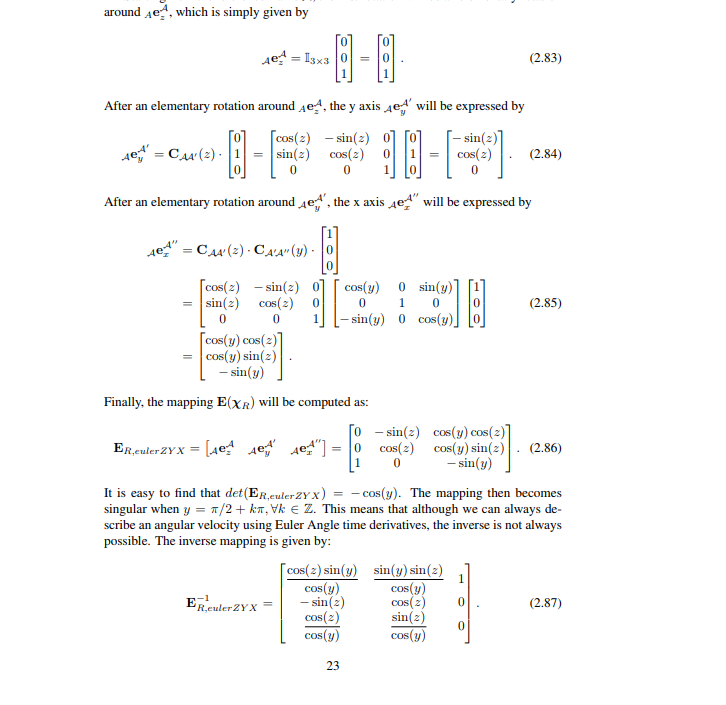

In [1]:
from pytransform3d.transform_manager import TransformManager

# Global Transform Manager
tm = TransformManager()

In [2]:
from pylab import plot, step, figure, subplot, legend, show, spy, xlabel, ylabel, title, xticks, yticks, xlim, ylim, gca, Rectangle

# Reference: http://ttuadvancedrobotics.wikidot.com/trajectory-planning-for-point-to-point-motion#toc1
# Cubic Polynomial Trajectory Helper Class
class CubicPolyTrajectory:
    def __init__(self, q_f, t_f, t_0=0, v_0=0, v_f=0, q_0=0):
        self.q_0 = q_0  # Initial Position
        self.q_f = q_f  # Final Position
        self.v_0 = v_0  # Initial Velocity
        self.v_f = v_f  # Final Velocity
        self.t_0 = t_0  # Inital Time
        self.t_f = t_f  # Final Time

        # Compute Coefficients
        self._compute()

    def evaluate(self, t):

        # Position
        q = self.a[0] + self.a[1] * t + self.a[2] * t**2 + self.a[3] * t**3

        # Velocity
        q_d = self.a[1] + 2 * self.a[2] * t + 3 * self.a[3] * t**2

        # Acceleration
        q_dd = 2 * self.a[2] + 6 * self.a[3] * t

        return q, q_d, q_dd

    # Evaluate at final position
    def evaluate_final(self):

        return self.evaluate(self.t_f)

    # Find polynomial coeeficients
    def _compute(self):

        # Find Cubic Coeeficients:
        C = np.array([[1, self.t_0, self.t_0**2, self.t_0**3],
                      [0, 1, 2 * self.t_0, 3 * self.t_0**2],
                      [1, self.t_f, self.t_f**2, self.t_f**3],
                      [0, 1, 2 * self.t_f, 3 * self.t_f**2]])

        b = np.array([[self.q_0], [self.v_0], [self.q_f], [self.v_f]])

        # Solve
        self.a = np.dot(np.linalg.inv(C), b)

    # Plotter function to see solved polynomial
    def plot(self):

        t = np.linspace(self.t_0, self.t_f, 100)
        q, q_d, q_dd = self.evaluate(t)

        # Plot
        figure()
        plot(t, q)
        xlabel('t')
        ylabel('q')
        title('Displacement (q)')

        figure()
        plot(t, q_d)
        xlabel('t')
        ylabel('q_d')
        title('Velocity (q_d)')

        figure()
        plot(t, q_dd)
        xlabel('t')
        ylabel('q_dd')
        title('Acceleration (q_dd)')

#traj = CubicPolyTrajectory(q_0 = 10, q_f=20, t_f=10)
#traj.plot()

In [3]:
# Notebook setups
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:75% !important; }</style>"))

%matplotlib inline

# Setup Better Debug Array Printing
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
#np.set_printoptions(edgeitems=10)
#np.core.arrayprint._line_width = 180

#np.set_printoptions(edgeitems=30, linewidth=100000,
#    formatter=dict(float=lambda x: "%.3g" % x))

# Notebook constant terms
gravity = 9.8
plot_gaits = False

# TODO LIST:
## * Need future footstep locations into the MPC
## PyBullet/V-Rep sim...

In [4]:
# TODO: Helpers.py blahh
import numpy as np
import scipy as sp
import scipy.linalg as la
import math

# Helper Rotation Matrices


# Rotation Matrix X-Axis (Roll)
def R_x(angle):
    c_th = np.cos(angle)
    s_th = np.sin(angle)
    return np.array([[1, 0, 0], [0, c_th, -s_th], [0, s_th, c_th]])


# Rotation Matrix Y-Axis (Pitch)
def R_y(angle):
    c_th = np.cos(angle)
    s_th = np.sin(angle)
    return np.array([[c_th, 0, s_th], [0, 1, 0], [-s_th, 0, c_th]])


# Rotation Matrix Z-Axis (Yaw)
def R_z(angle):
    c_th = np.cos(angle)
    s_th = np.sin(angle)
    return np.array([[c_th, -s_th, 0], [s_th, c_th, 0], [0, 0, 1]])


# World Space Angular Velocity to Body Space Euler Angle Transformation
def R_omega(phi, theta, psi, linearize=False):

    c_phi = np.cos(phi)
    s_phi = np.sin(phi)

    c_th = np.cos(theta)
    s_th = np.sin(theta)
    t_th = np.tan(theta)

    c_psi = np.cos(psi)
    s_psi = np.sin(psi)

    # Linearized appoximation for small angles of phi and theta(roll and pitch)
    if linearize == True:
        return np.array([[c_psi, s_psi, 0], [-s_psi, c_psi, 0], [0, 0, 1]])

    # Return Non-Linear Version
    return np.array([[c_psi / c_th, s_psi / c_th, 0], [-s_psi, c_psi, 0],
                     [c_psi * t_th, s_psi * t_th, 1]])
                    #[c_psi/c_th, s_psi/c_th, 1]])


# Rotation Transformation Matrix from vector_orig to vector_fin
def R_2vec(R, vector_orig, vector_fin):

    # Convert the vectors to unit vectors.
    vector_orig = vector_orig / np.linalg.norm(vector_orig)
    vector_fin = vector_fin / np.linalg.norm(vector_fin)

    # The rotation axis (normalised).
    axis = np.cross(vector_orig, vector_fin)
    axis_len = np.linalg.norm(axis)
    if axis_len != 0.0:
        axis = axis / axis_len

    # Alias the axis coordinates.
    x = axis[0]
    y = axis[1]
    z = axis[2]

    # The rotation angle.
    angle = math.acos(np.dot(vector_orig, vector_fin))

    # Trig functions (only need to do this maths once!).
    ca = math.cos(angle)
    sa = math.sin(angle)

    # Calculate the rotation matrix elements.
    R[0, 0] = 1.0 + (1.0 - ca) * (x**2 - 1.0)
    R[0, 1] = -z * sa + (1.0 - ca) * x * y
    R[0, 2] = y * sa + (1.0 - ca) * x * z
    R[1, 0] = z * sa + (1.0 - ca) * x * y
    R[1, 1] = 1.0 + (1.0 - ca) * (y**2 - 1.0)
    R[1, 2] = -x * sa + (1.0 - ca) * y * z
    R[2, 0] = -y * sa + (1.0 - ca) * x * z
    R[2, 1] = x * sa + (1.0 - ca) * y * z
    R[2, 2] = 1.0 + (1.0 - ca) * (z**2 - 1.0)


# Helper Slicing and indexing for "vector" matrices with a stride
def get_slice(A, row, col, num_rows, num_cols, row_stride=3, col_stride=3):
    row_idx = row * row_stride
    col_idx = col * col_stride
    return A[row_idx:row_idx + num_rows, col_idx:col_idx + num_cols]


# Should be able to "get slice" and then set it.  Probably do not need this function
def set_slice(A, row, col, val, row_stride=3, col_stride=3):

    row_idx = row * row_stride
    col_idx = col * col_stride

    A[row_idx:row_idx + val.shape[0], col_idx:col_idx + val.shape[1]] = val


# https://en.wikipedia.org/wiki/Cross_product#Skew-symmetric_matrix
def cross_product_skew_matrix(vec):
    return np.array([[0, -vec[2], vec[1]], [vec[2], 0, -vec[0]],
                     [-vec[1], vec[0], 0]])


def vector_normalize(vec):

    ret_vec = np.zeros(3)
    length = vector_magnitude(vec)

    if (length > 0):
        ret_vec = vec / length
    return ret_vec


def vector_magnitude(vec):
    return np.sqrt(vec.dot(vec))


# Remap a range from -> to
def value_map(value, istart, istop, ostart, ostop):
    return ostart + (ostop - ostart) * ((value - istart) / (istop - istart))


# Continuous time to Discrete time zero-order hold method
def c2d_zoh(A, B, Ts):
    # Zero Order Hold Discrate Time Model
    nx = A.shape[0]
    nu = B.shape[1]

    # Create Extended Linear System
    M = np.zeros((nx + nu, nx + nu))
    M[0:nx, 0:nx] = A * Ts
    M[0:nx, nx:] = B * Ts
    M_d = la.expm(M)  # Convert to Discrete Time

    A_d = M_d[0:nx, 0:nx]  # Pull out A Matrix
    B_d = M_d[0:nx, nx:]  # Pull out B Matrix

    return A_d, B_d


# Helper for plotting on gaits. Divides up a vector based on integer continuity
# [1,2,3,4,5,9,10,11,12] -> [[1,2,3,4,5], [9,10,11,12]]
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

### Gait Sequencing

![Gaits](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Gait_graphs_v2.png/1920px-Gait_graphs_v2.png)


In [5]:
from pylab import plot, step, figure, legend, show, spy, xlabel, ylabel, title, xticks, yticks, xlim, ylim, gca, Rectangle

# TODO: Change this to more of a single stance/swing phase with offsets to define gaits
# Gait sequencer base class.  Takes in a period, and number of segments
class GaitSequencer:
    def __init__(self, period, segments=100):
        self.period = period  # Period of the gait
        self.freq = 1 / period  # Frequency of the gait
        self.segments = segments  # Number of segments to divide the gait into
        self.leg_phase = []  # Array to hold the leg phase
        self.leg_stance_times = []  # Array to hold stance phase durations
        self.leg_swing_times = []  # Array to hold swing phase durations
        self.sync_time = 0.0  # Gait synchronization time.  Probably a better way to do this
        self._setup()  # Virtual setup function for subclassed gaits
        self.name = "Gait"

    # Override this to setup custom gaits in sub classes
    def _setup(self):
        raise NotImplementedError()

    # Sync phase variable
    def start(self, sync_time):
        self.sync_time = sync_time

    # Clock in seconds or maybe we do ms
    def get_contact_phases(self, clock):

        # Map clock to 0 to 1 to get gait contact phase
        t = (clock - self.sync_time) / self.period
        t = t - int(t)

        return self.leg_phase[:, int(t * self.segments)]

    # Returns how long the stance phase duration is
    def get_stance_times(self):
        return self.leg_stance_times[:]

    # Returns how long the swing phase duration is
    def get_swing_times(self):
        return self.leg_swing_times[:]

    # Cool little horizontal line plot of the gait sequence
    def plot(self):

        num_legs = self.leg_phase.shape[0]
        # Setup Plot
        figure()
        xticks(range(0, 101, 10))
        yticks(np.arange(5), ('', 'Right Rear(0)', 'Right Front(1)',
                              'Left Front(2)', 'Left Rear(3)', ''))
        xlabel("Gait Cycle Time (Percentage)")
        gca().set_xticklabels(
            ['{:.0f}%'.format(x) for x in gca().get_xticks()])

        xlim(0, 100)
        ylim(0, 5)
        ylabel("Leg")
        rect_height = 0.5
        title(self.name)

        #Plot It
        for i in range(num_legs):
            t_vec = consecutive(np.nonzero(
                self.leg_phase[i] == 1)[0])  # Get Stance phases only to plot

            for j in range(len(t_vec)):
                x_offset = (t_vec[j][0] / (self.segments)) * 100
                x_width = (t_vec[j][-1] / (self.segments)) * 100 - x_offset

                rectangle = Rectangle((x_offset, (i + 1) - rect_height / 2),
                                      x_width,
                                      rect_height,
                                      fc='k')
                gca().add_patch(rectangle)


# Running Trot Gait Sequencer (Opposite diagonal leg pairs are synced)
class RunningTrotGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Running Trot"

    def _setup(self):
        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        # Right Rear (50% to 90%(40% Total Stance Time) of gait cycle in stance)
        self.leg_phase[0,
                       int(self.segments * 0.5):-int(self.segments * 0.1) + 1] = 1

        # Right Front (0% to 40% of gait cycle in stance)
        self.leg_phase[1, 0:int(self.segments * 0.4) + 1:] = 1

        # Left Front (50% to 90%(40% Total Stance Time) of gait cycle in stance)
        self.leg_phase[2,
                       int(self.segments * 0.5):-int(self.segments * 0.1) + 1] = 1

        # Left Rear (0% to 40% of gait cycle in stance)
        self.leg_phase[3, 0:int(self.segments * 0.4) + 1:] = 1

        # Stance and swing time percentages
        self.leg_stance_times[:] = self.period * 0.4
        self.leg_swing_times[:] = self.period * 0.6


# Walking Trot Gait Sequencer (Opposite diagonal leg pairs are synced)
class WalkingTrotGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Walking Trot"

    def _setup(self):
        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        # Right Rear (0% to 10%/50% to 100% = 60% Total w/ Overlap) of gait cycle in stance)
        self.leg_phase[0, 0:int(self.segments * 0.1) + 1] = 1
        self.leg_phase[0, int(self.segments * 0.5):] = 1

        # Right Front (0% to 60% of gait cycle in stance)
        self.leg_phase[1, 0:int(self.segments * 0.6) + 1:] = 1

        # Left Front (0% to 10%/50% to 100% = 60% Total w/ Overlap) of gait cycle in stance)
        self.leg_phase[2, 0:int(self.segments * 0.1) + 1] = 1
        self.leg_phase[2, int(self.segments * 0.5):] = 1

        # Left Rear (0% to 60% of gait cycle in stance)
        self.leg_phase[3, 0:int(self.segments * 0.6) + 1:] = 1

        # Stance and swing time percentages
        self.leg_stance_times[:] = self.period * 0.6
        self.leg_swing_times[:] = self.period * 0.4


# Running Pace Gait Sequencer (Both lateral sides are synced)
class RunningPaceGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Running Pace"

    def _setup(self):

        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        # Right Rear (50% to 100% of gait cycle in stance)
        self.leg_phase[0,
                       int(self.segments * 0.5):-int(self.segments * 0.1) + 1] = 1

        # Right Front (50% to 100% of gait cycle in stance)
        self.leg_phase[1,
                       int(self.segments * 0.5):-int(self.segments * 0.1) + 1] = 1

        # Left Front (0% to 50% of gait cycle in stance)
        self.leg_phase[2, 0:int(self.segments * 0.4) + 1:] = 1

        # Left Rear (0% to 50% of gait cycle in stance)
        self.leg_phase[3, 0:int(self.segments * 0.4) + 1:] = 1

        # Stance and swing time percentages
        self.leg_stance_times[:] = self.period * 0.5
        self.leg_swing_times[:] = self.period * 0.5


# Walking Pace Gait Sequencer (Opposite diagonal leg pairs are synced)
class WalkingPaceGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Walking Pace"

    def _setup(self):
        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        # Right Rear (0% to 10%/50% to 100% = 60% Total w/ Overlap) of gait cycle in stance)
        self.leg_phase[0, 0:int(self.segments * 0.1) + 1] = 1
        self.leg_phase[0, int(self.segments * 0.5):] = 1

        # Right Front (0% to 60% of gait cycle in stance)
        self.leg_phase[1, 0:int(self.segments * 0.1) + 1] = 1
        self.leg_phase[1, int(self.segments * 0.5):] = 1

        # Left Front (0% to 10%/50% to 100% = 60% Total w/ Overlap) of gait cycle in stance)
        self.leg_phase[2, 0:int(self.segments * 0.6) + 1:] = 1

        # Left Rear (0% to 60% of gait cycle in stance)
        self.leg_phase[3, 0:int(self.segments * 0.6) + 1:] = 1

        # Stance and swing time percentages
        self.leg_stance_times[:] = self.period * 0.6
        self.leg_swing_times[:] = self.period * 0.4


# Lateral Sequence Walk Gait Sequencer
class LateralSeqWalkGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Lateral Sequence Walk"

    def _setup(self):
        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        # Right Rear ((0% to 20%/50% to 100% = 70% Total w/ Overlap) of gait cycle in stance)
        self.leg_phase[0, 0:int(self.segments * 0.2) + 1] = 1
        self.leg_phase[0, int(self.segments * 0.5):] = 1

        # Right Front ((10% to 80% = 70% Total) of gait cycle in stance)
        self.leg_phase[1,
                       int(self.segments * 0.1):int(self.segments * 0.8) + 1:] = 1

        # Left Front ((0% to 30%/60% to 100% = 70% Total w/ Overlap) of gait cycle in stance)
        self.leg_phase[2, 0:int(self.segments * 0.3) + 1] = 1
        self.leg_phase[2, int(self.segments * 0.6):] = 1

        # Left Rear (0% to 70% of gait cycle in stance)
        self.leg_phase[3, 0:int(self.segments * 0.7) + 1:] = 1

        # Stance and swing time percentages
        self.leg_stance_times[:] = self.period * 0.7
        self.leg_swing_times[:] = self.period * 0.3


# Bounding Gait Sequencer (Both Front and Rear sides are synced)
class BoundingGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Bounding Gait"

    def _setup(self):

        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        # Right Rear (0% to 30% of gait cycle in stance)
        self.leg_phase[0, 0:int(self.segments * 0.3) + 1] = 1

        # Right Front (40% to 70% of gait cycle in stance)
        self.leg_phase[1,
                       int(self.segments * 0.4):int(self.segments * 0.7) + 1] = 1

        # Left Front (40% to 70% of gait cycle in stance)
        self.leg_phase[2,
                       int(self.segments * 0.4):int(self.segments * 0.7) + 1] = 1

        # Left Rear (0% to 30% of gait cycle in stance)
        self.leg_phase[3, 0:int(self.segments * 0.3) + 1] = 1

        # Stance and swing time percentages
        self.leg_stance_times[:] = self.period * 0.3
        self.leg_swing_times[:] = self.period * 0.7


# Pronking Gait Sequencer (Both Front and Rear sides are synced)
class PronkingGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Pronking Gait"

    def _setup(self):

        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        # Right Rear (0% to 30% of gait cycle in stance)
        self.leg_phase[0, 0:int(self.segments * 0.3) + 1] = 1

        # Right Front (0% to 30% of gait cycle in stance)
        self.leg_phase[1, 0:int(self.segments * 0.3) + 1] = 1

        # Left Front (0% to 30% of gait cycle in stance)
        self.leg_phase[2, 0:int(self.segments * 0.3) + 1] = 1

        # Left Rear (0% to 30% of gait cycle in stance)
        self.leg_phase[3, 0:int(self.segments * 0.3) + 1] = 1

        # Stance and swing time percentages
        self.leg_stance_times[:] = self.period * 0.3
        self.leg_swing_times[:] = self.period * 0.7


# Standing "gait".  Does nothing really but keep all 4 feet in contact.  Seems like a useful thing to keep things consistent.  TBD
class StandingGaitSequencer(GaitSequencer):
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Standing Gait"

    def _setup(self):
        # Zero is swing space, #One is a stance phase
        self.leg_phase = np.ones((4, self.segments))
        self.leg_stance_times = np.zeros(4)
        self.leg_swing_times = np.zeros(4)

        self.leg_stance_times[:] = self.period * 1.0
        self.leg_swing_times[:] = 0.0


# TODO: Gaits:
# Rotary Gallop
# Transverse Gallop

# Test it
if (plot_gaits):
    gaits = []
    gaits.append(StandingGaitSequencer(period=1.0, segments=100))
    gaits.append(LateralSeqWalkGaitSequencer(period=1.0, segments=100))
    gaits.append(WalkingPaceGaitSequencer(period=1.0, segments=100))
    gaits.append(RunningPaceGaitSequencer(period=1.0, segments=100))
    gaits.append(WalkingTrotGaitSequencer(period=1.0, segments=100))
    gaits.append(RunningTrotGaitSequencer(period=1.0, segments=100))
    gaits.append(BoundingGaitSequencer(period=1.0, segments=100))
    gaits.append(PronkingGaitSequencer(period=1.0, segments=100))

    for gait in gaits:
        gait.start(0)
        gait.plot()

In [6]:
#TODO:
# Need Leg Jacobian
# Trajectory Planner Ramping
# More feasible trajectory planning!, Cubic Polynomials?


# Init Meshcat visualizer
import meshcat
import meshcat.geometry as geom
import meshcat.transformations as mc_tf
import time

# Create a new visualizer
vis = meshcat.Visualizer()

vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [7]:
class TransformPoseVisualizer:
    
    def __init__(self):
        return
        
    # Meshcat Visualizer Intialize
    def init_visualizer(self, vis):
        
        # Setup
        self.vis = vis
        self.vis_root = vis["Reference Frames"]
        self.vis_root.delete()
        self.vis_frames = []
        self.arrow_height = 0.05
        self.origin_sphere_diam = 0.015
        
        # Add Materials
        self.materials = {
            "red": geom.MeshLambertMaterial(color=0xff0000, reflectivity=0.8),
            "green": geom.MeshLambertMaterial(color=0x00ff00, reflectivity=0.8),
            "blue": geom.MeshLambertMaterial(color=0x0000ff, reflectivity=0.8),
            "magenta": geom.MeshLambertMaterial(color=0xff22dd, reflectivity=0.8),     
            "white": geom.MeshLambertMaterial(color=0xeeeeee, reflectivity=0.8),
            "white-trans":geom.MeshLambertMaterial(color=0xeeeeeee, reflectivity=0.8, transparent=True, opacity=0.1)
        }

        frame = self.vis_root["world"]
        frame.set_object(geom.Sphere(self.origin_sphere_diam), self.materials["magenta"])
        self.vis_frames.append(frame)
        
        for frame_name in tm.nodes:
            self.vis_root[frame_name].set_object(geom.Sphere(self.origin_sphere_diam), self.materials["magenta"])
            self.vis_root[frame_name]["X"].set_object(geom.Cylinder(height=0.2, radius=0.005,), self.materials["red"])
            self.vis_root[frame_name]["Y"].set_object(geom.Cylinder(height=0.2, radius=0.005,), self.materials["green"])
            self.vis_root[frame_name]["Z"].set_object(geom.Cylinder(height=0.2, radius=0.005,), self.materials["blue"])
            
    #Meshcat Visualizer Renderer
    def render(self):
        
        for frame_name in tm.nodes:
            
            # Passive to Active transformation
            pose_xform = tm.get_transform(frame_name, "world_frame")
            self.vis_root[frame_name].set_transform(pose_xform)

            # Rotation transformation for the debug geometry for the GRF
            R_x = np.eye(4)
            R_y = np.eye(4)
            R_z = np.eye(4)
        
            vec1 = np.array([0,1,0]) # Map Y-Axis of cylinder to force axis
            R_2vec(R_x, vec1, [1,0,0])
            R_2vec(R_y, vec1, [0,1,0])
            R_2vec(R_z, vec1, [0,0,1])

            axis_xform = R_x
            axis_xform = axis_xform.dot(mc_tf.translation_matrix([0.0,0.1,0]))
            self.vis_root[frame_name]["X"].set_transform(axis_xform)

            axis_xform = R_y
            axis_xform = axis_xform.dot(mc_tf.translation_matrix([0.0,0.1,0]))
            self.vis_root[frame_name]["Y"].set_transform(axis_xform)

            axis_xform = R_z
            axis_xform = axis_xform.dot(mc_tf.translation_matrix([0.0,0.1,0]))
            self.vis_root[frame_name]["Z"].set_transform(axis_xform)
            
pose_vis = TransformPoseVisualizer()
pose_vis.init_visualizer(vis)
pose_vis.render()

In [8]:
import numpy as np
from enum import Enum

class LegState(Enum):
    # Swing State
    SWING = 0

    # Stance State
    STANCE = 1

# TODO: Events and Trasnsitions and Handlers
# handlers[event] = function
class LegEvent(Enum):
    TOUCHDOWN = 0
    LIFTOFF = 1


class LegSwingController:
    def __init__(self, leg_id=0, Ts=1e-1):

        # TODO: Need some sort of reset function to put everything back to "0"
        self.state = LegState.STANCE  # Leg State, Are we swing or stance?
        self.leg_id = leg_id  # ID of the leg from robot
        self.step_height = 0.2  # Default stepping height in swing
        self.gait_sequencer = StandingGaitSequencer(period=1.0, segments=2)  # Default gait.  Just stand
        self.t = 0  # Current Time
        self.Ts = Ts  # Sampling time
        self.t_swing_start = 0  # Swing Start Time, used to sync the trajectory evaluations in the swing stage
        self.t_swing_end = 0  # Swing End Time(Goes into stance)
        self.body_state = np.zeros((13, 1))  # CoM Body State

        # For now just these points are enough for testing
        self.hip_offset = np.array([0, 0, 0])  # Hip offset from the main body
        
        # Track offset for foot from the main body/hip.  Can be adjusted to reduce pitch/roll moments on CoM
        self.track_offset = np.array([0, 0, 0])  

        # Position of the foot in World Frame
        self.foot_pos = np.array([0, 0, 0])
        
        # Leg Trajectories
        # Hold onto the swing leg trajectory generators.  
        # 1 for x, 1 for y, and 2 for z motion(going up and back down)
        self.foot_trajectory = [None] * 4

    # Set Hip Transform
    def set_hip_base_frame(self, name):
        self.hip_base_frame = name

    # Set Hip Transform
    #def set_hip_offset(self, offset):
    #    self.hip_offset = offset

    def set_track_offset(self, offset):
        self.track_offset = offset

    def set_step_height(self, height):
        self.step_height = height

    def set_gait(self, gait_sequencer):
        self.gait_sequencer = gait_sequencer

    def update_body_state(self, x):
        self.body_state = x

    def _updateFSM(self):
        contact_state = self.gait_sequencer.get_contact_phases(self.t)[self.leg_id]

        if self.state is LegState.STANCE:
            # TODO: Save last body position.  When in stance offset stance foot by body position change
            # Check for liftoff
            if (contact_state == 0): # Transition from stance to swing
                
                # In Swing state now.  Setup transition
                self.state = LegState.SWING
                
                # Get p_des in world frame - next foot position at stance location
                self.p_des = self.get_next_stance_pos()

                # Swing Time
                self.T_swing = self.gait_sequencer.get_swing_times()[self.leg_id]
                
                # Setup time boundary conditions for swing leg trajectory
                self.t_swing_start = self.t
                self.t_swing_end = self.t + self.T_swing
                self.last_stance = self.foot_pos
                
                # Compute Swing Trajectories (in Body Frame)
                self.foot_trajectory[0] = CubicPolyTrajectory(q_0=self.foot_pos[0], q_f=self.p_des[0], t_f=self.T_swing)  # X
                self.foot_trajectory[1] = CubicPolyTrajectory(q_0=self.foot_pos[1], q_f=self.p_des[1], t_f=self.T_swing)  # Y
                self.foot_trajectory[2] = CubicPolyTrajectory(q_0=self.foot_pos[2], 
                                                              q_f=self.foot_pos[2] + self.step_height,
                                                              t_f=self.T_swing / 2)  # Z Up
                self.foot_trajectory[3] = CubicPolyTrajectory(q_0=self.foot_pos[2] + self.step_height,
                                                              q_f=self.p_des[2],
                                                              t_0=self.T_swing / 2,
                                                              t_f=self.T_swing)  # Z Down
                return

        elif self.state is LegState.SWING:

            # Check for touchdown
            if (contact_state == 1):
                
                # In Stance state now.  Setup transition
                self.state = LegState.STANCE

                # Update the WF position for the foot.
                self.foot_pos[2] = 0
                return

            swing_time = self.t - self.t_swing_start  # Current T-Delta in swing trajectory time
            self.p_des = self.get_next_stance_pos()
            # TODO: Need to also pass in velocities to the trajectory...
            self.foot_trajectory[0] = CubicPolyTrajectory(q_0=self.last_stance[0], 
                                                          q_f=self.p_des[0], 
                                                          t_f=self.T_swing)  # X
            self.foot_trajectory[1] = CubicPolyTrajectory(q_0=self.last_stance[1], 
                                                          q_f=self.p_des[1], 
                                                          t_f=self.T_swing)  # Y

            # Follow Swing Trajectory
            q_x, _, _ = self.foot_trajectory[0].evaluate(swing_time)  # evaluate for the x position
            q_y, _, _ = self.foot_trajectory[1].evaluate(swing_time)  # evaulate for the y position

            # 2 part evaluation for the z position
            if (swing_time <= self.foot_trajectory[2].t_f):
                q_z, _, _ = self.foot_trajectory[2].evaluate(swing_time)
            else:
                q_z, _, _ = self.foot_trajectory[3].evaluate(swing_time)

            # Update swing position
            self.foot_pos = np.array([q_x[0], q_y[0], q_z[0]]).flatten()
         
    # Returns foot position in desired "to_frame_id"
    def get_foot_pos(self, to_frame_id):

        # Get transform from the hip base frame to the world
        foot_xform = tm.get_transform("world_frame", to_frame_id)
        return pt.transform(foot_xform, pt.vector_to_point(self.foot_pos))[:3]

    # Get the next leg stance position in world frame
    def get_next_stance_pos(self):

        self.T_stance = self.gait_sequencer.get_stance_times()[self.leg_id]

        # Get CoM Position/Velocity/Orientation
        v_com = self.body_state[3:6].flatten()
        v_com[2] = 0 # Remove Z Component of velocity

        # Get transform from the hip base frame to the world
        hip_frame = tm.get_transform(self.hip_base_frame, "world_frame")

        # Get foot position at this point.  Just straight down from hip
        p_ref = pt.transform(hip_frame, pt.vector_to_point(self.track_offset))[:3]

        # Computed Next Stance Position (World Frame)
        
        # Get P_des   [Get Hip Offset in World Frame]   +   [Raibert heuristic]
        p_des = p_ref + v_com * (0.5 * self.T_stance)
        
        return p_des

    # Reset the leg
    def reset(self):

        # Default in stance
        self.state = LegState.STANCE

        # Get transform from the hip base frame to the world
        hip_frame = tm.get_transform(self.hip_base_frame, "world_frame")

        # Get foot position at this point.  Just straight down from hip
        self.foot_pos = pt.transform(hip_frame, pt.vector_to_point(self.track_offset))[:3]
        
        # Reset the gait clock
        self.gait_sequencer.start(0)
        #self.foot_pos[2] = 0  # Project to ground

    def render(self, vis):
        return

    def step(self):

        # Update state
        self._updateFSM()

        # Update Time
        self.t += self.Ts

In [9]:
# Notes
# I_p = Principle Axes of Inertia = [Ixx, Iyy, Izz]
# width is on Body Frame Y Axis
# height is on Body Frame Z Axis
# length is on Body Frame X Axis

import numpy as np
import pytransform3d.rotations as pr
import pytransform3d.transformations as pt



class FloatingBaseRigidBody:
    
    def __init__(self, mass, I_p, width, height, length, Ts = 1e-1, num_forces = 1):
        
        # Mass / Inertia and Gravity
        self.mass = mass           # Body mass [kg]
        self.I_b = np.diag(I_p, 0) # Body Inertia Tensor[kgm^2]
        self.g = gravity            # Gravity [m/s^2]
        
        # Body Geometry, #TODO: Auto calculate I_b?
        self.width = width # Width of Body [m]
        self.height = height # Height of Body [m]
        self.length = length # Length of Body [m]
        
        # Misc. Parameters
        self.num_forces = num_forces # Number of force producing elements, GRFs, Thrusters etc
        self.num_states = 13 # Total number of 6 dof states, xyz positions(+ derivatives), phi, theta, psi(+angular velocities) + augmented gravity
        self.num_inputs = num_forces * 3 # 3D Force Vectors
        
        # State Space Dynamics
        # x = [x,y,z,x',y',z', phi,theta,psi,omega_x,omega_y,omega_z,g].T
        self.A = np.zeros([self.num_states, self.num_states]) #System Matrix
        self.B = np.zeros([self.num_states, self.num_inputs]) #Input Matrix
        self.x = np.zeros((self.num_states,1)) # Body State
        self.x[-1] = self.g # Copy in to the Gravity state
        self.u = np.zeros((self.num_inputs, 1)) # Force Input
        
        self.t = 0 # Current Time
        self.Ts = Ts # Sampling time
        self.rot_body = np.eye(3) # Rotation transformation matrix for Body Orientation
        
        # Default Force Application Positions
        self.p_force = np.zeros([self.num_forces, 3]) # World Frame location of forces
        self.r = np.zeros([self.num_forces, 3]) # World Frame Force to Torque Vector(CoM -> Force Application Position)
        
        # Min/Max Forces Envelope
        self.force_min = -666
        self.force_max = 666
        
        # Meshcat Visualization
        self.vis = None
        
    # CoM Position
    def get_com_pos(self):
        return self.x[0:3].flatten()
    
    # CoM Velocity
    def get_com_vel(self):
        return self.x[3:6].flatten()
    
    # CoM Orientation (Body Frame)
    def get_orientation(self):
        return self.x[6:9].flatten()
    
    # CoM Angular Velocity (World Frame)
    def get_angular_vel(self):
        return self.x[9:12].flatten()
    
    # CoM Position
    def set_com_pos(self, pos):
        self.x[0:3] = pos.reshape(3,-1)
    
    # CoM Velocity
    def set_com_vel(self, vel):
        self.x[3:6] = vel.reshape(3,-1)
    
    # CoM Orientation (Body Frame)
    def set_orientation(self, theta):
        self.x[6:9] = theta.reshape(3,-1)
    
    # CoM Angular Velocity (World Frame)
    def set_angular_vel(self, omega):
        self.x[9:12] = omega.reshape(3,-1)
    
    # World Frame positions of force 
    def set_force_locations(self, force_pos):
        self.p_force = force_pos
    
    # Step simulation
    def step(self):
        raise NotImplementedError()
        
    def init_visualizer(self, vis):
        pass
    
    def render(self):
        pass

# Subclassed floating base for 4 legged quadruped support
class QuadrupedFloatingBase(FloatingBaseRigidBody):
        
    def __init__(self, mass, I_p, width, height, length, Ts = 1e-1):
        super().__init__(mass, I_p, width, height, length, Ts, num_forces = 4)
        
        # Min and Max Forces:
        self.force_min = 10
        self.force_max = 666
        
        # Default gait sequencer
        self.gait_sequencer = StandingGaitSequencer(period = 0.5, segments = 100)
        self.gait_sequencer.start(0)
        
        # Setup Leg controllers
        self.leg_controllers = []
        # TODO: Sampling time needs to be higher/different here.  Different update rates
        # For different controllers
        self.leg_controllers.append(LegSwingController(0, self.Ts))
        self.leg_controllers.append(LegSwingController(1, self.Ts))
        self.leg_controllers.append(LegSwingController(2, self.Ts))
        self.leg_controllers.append(LegSwingController(3, self.Ts))
        
        #self.leg_controllers[0].set_hip_offset(np.array([-self.length/2, self.width/2, 0]))  # Right Rear Leg
        #self.leg_controllers[1].set_hip_offset(np.array([self.length/2, self.width/2, 0]))   # Right Front Leg
        #self.leg_controllers[2].set_hip_offset(np.array([self.length/2, -self.width/2, 0]))  # Left Front Leg
        #self.leg_controllers[3].set_hip_offset(np.array([-self.length/2, -self.width/2, 0])) # Left Rear LEg
        
        self._update_transforms()
            
        # Is this better from body frame or base_link?  i.e. does the hip to ground projections need to account for body
        # pitch, and roll orientations.  Seems to work better in a "2D" representation
        tm.add_transform("hip_frame_0", "base_link", pt.transform_from(np.eye(3).T, # Right Rear Leg
                                                                        np.array([-self.length/2, self.width/2, 0])))
        tm.add_transform("hip_frame_1", "base_link", pt.transform_from(np.eye(3).T, # Right Front Leg
                                                                        np.array([self.length/2, self.width/2, 0])))
        tm.add_transform("hip_frame_2", "base_link", pt.transform_from(np.eye(3).T, # Left Front Leg
                                                                        np.array([self.length/2, -self.width/2, 0])))
        tm.add_transform("hip_frame_3", "base_link", pt.transform_from(np.eye(3).T, # Left Rear Leg
                                                                        np.array([-self.length/2, -self.width/2, 0])))
        
        self.leg_controllers[0].set_hip_base_frame("hip_frame_0")
        self.leg_controllers[1].set_hip_base_frame("hip_frame_1")
        self.leg_controllers[2].set_hip_base_frame("hip_frame_2")
        self.leg_controllers[3].set_hip_base_frame("hip_frame_3")
        
        # Update Step Height
        for leg in self.leg_controllers:
            leg.set_step_height(0.2)
        
        # Udpdate Track Offset
        self.set_track_offset(0.0) # default to no hip offset
        
        # TODO: Remove this
        self.reset_foot_positions()
      
    def _update_transforms(self):
        # Update Reference Frames
        base_link2world = pt.transform_from(pr.matrix_from_euler_zyx(np.array([self.get_orientation()[2], 0.0, 0.0])).T,
                                                                     np.array([self.get_com_pos()[0], 
                                                                               self.get_com_pos()[1], 
                                                                               0.0]))
        
        body_frame2world = pt.transform_from(pr.matrix_from_euler_zyx(np.array([self.get_orientation()[2], 
                                                                                self.get_orientation()[1], 
                                                                                self.get_orientation()[0]])).T, 
                                                                                self.get_com_pos())
        
        
        tm.add_transform("base_link", "world_frame", base_link2world)
        tm.add_transform("body_frame", "world_frame", body_frame2world)
        
    # "Track Parameter" from Raibert Dynamically Stable Legged Locomotion, Ch. 5, Page 120
    # This value if an offset from the hip location.  In the case of some gaits such as the
    # pace it can be used to reduce body moments by changing where the force is applied to 
    # closer to the CoM
    def set_track_offset(self, offset):
        
        self.track_offset = offset
        
        self.leg_controllers[0].set_track_offset(np.array([0, -self.track_offset, 0]))  # Right Rear Hip
        self.leg_controllers[1].set_track_offset(np.array([0, -self.track_offset, 0]))   # Right Front Hip
        self.leg_controllers[2].set_track_offset(np.array([0, self.track_offset, 0]))  # Left Front Hip
        self.leg_controllers[3].set_track_offset(np.array([0, self.track_offset, 0])) # Left Rear Hip
        
    def set_gait(self, gait):
        self.gait_sequencer = gait
        self.gait_sequencer.start(0)
        
        for leg in self.leg_controllers:
            leg.set_gait(gait)

    def get_gait(self):
        return self.gait_sequencer
    
    # R_w = transformation from WCS angular velocity to body pitch, roll and yaw
    # TODO: Add reference docs
    #########################################################
    # A Matrix Form augmented with the gravity term
    # [0_3, 1_3, 0_3,   0_3, 0] = p
    # [0_3, 0_3, 0_3,   0_3, g] = p'
    # [0_3, 0_3, 0_3,   R_w, 0] = theta
    # [0_3, 0_3, 0_3,   0_3, 0] = omega

    # *B Matrix = R^13x3xn where n is number of feet in contant
    # B Matrix Form (I=Body Inertia in World Frame, r_n = CoM->Support Leg vector, m = body mass)
    # [0_3,       0_3,      0_3,        0_3,       0] = p
    # [1_3/m,     1_3/m,    1_3/m,      1_3/m,     0] = p'
    # [0_3,       0_3,      0_3,        0_3,       0] = theta
    # [I^-1[r_1], I^-1[r_2], I^-1[r_3], I^-1[r_4], 0] = omega
    
    ###########################################################
    # Orientation parameter is in format [phi, theta, psi](roll, pitch and yaw)
    def get_A_Matrix(self, orientation, linearize = False):
        
        A = np.zeros((self.num_states, self.num_states))
        R_w = R_omega(phi = orientation[0], theta = orientation[1], psi = orientation[2], linearize = linearize)
        set_slice(A,row=0,col=1,val=np.eye(3)) # Set Identity submatrix
        set_slice(A,row=2,col=3,val=R_w) # Set Rotation submatrix
        A[5,12] = -1 # Augment State Transition for gravity constant term
        return A

    # Orientation parameter is in format [phi, theta, psi](roll, pitch and yaw)
    # TODO: Also need foot placement for this as well
    def get_B_Matrix(self, orientation, contacts = [1,1,1,1], linearize = False):
        
        B = np.zeros((self.num_states, self.num_inputs))
        R = np.eye(3) # Body rotation transform
        
        if linearize is True: # Just the yaw, ignore pitch and roll for better linear approximation
            R = R_z(orientation[2])
        else: # Non linear full body rotation
            R = R_z(orientation[2])@R_y(orientation[1])@R_x(orientation[0])

        I = R@self.I_b@R.T # Transform from body frame inertia to space frame inertia
        I_inv = np.linalg.inv(I) # Take the inverse and cache it

        # Force application point map
        # TODO: This needs to be passed in as a parameter from foot placement controller(TODO)
        r_nx = [cross_product_skew_matrix(self.r[0]),
               cross_product_skew_matrix(self.r[1]),
               cross_product_skew_matrix(self.r[2]),
               cross_product_skew_matrix(self.r[3])]
        
        # Set Row 2 of the B Matrix
        # Also Augment B with contact states(zero out force inputs for those legs in the air)
        for i in range(self.num_forces):
            set_slice(B,row=1,col=i,val=np.eye(3)/self.mass*contacts[i]) 

        # Set Row 4 of the B Matrix
        # Also Augment B with contact states(zero out force inputs for those legs in the air)
        for i in range(self.num_forces):
            set_slice(B,row=3,col=i,val=I_inv@r_nx[i]*contacts[i]) 
            
        return B
    
    def get_model_matrices(self, state_trajectory = None):
        
        # Return Matrices
        A_d_out = [] # Discrete A
        B_d_out = [] # Discrete B
        A_out = [] # Continuous A (Do we really need this?)
        B_out = [] # Continuous B (Do we really need this?)
        
        if state_trajectory is None: # Use Current State
            
            # Grab the current foot in stance/swing contact states
            contact_state = self.gait_sequencer.get_contact_phases(self.t)
        
            A = self.get_A_Matrix(self.get_orientation(), False)
            B = self.get_B_Matrix(self.get_orientation(), contact_state, False)
            
            # Continuous to Discrete Time Conversion
            A_d, B_d = c2d_zoh(A, B, self.Ts)
        
            A_out.append(A)
            B_out.append(B)
            A_d_out.append(A_d)
            B_d_out.append(B_d)
        
        else:
            # Cache some values
            # Old Force Locations, etc
            # Loop over the state trajectory horizon
            for i in range(state_trajectory.shape[1]):
                
                # Grab the current foot in stance/swing contact states
                contact_state = self.gait_sequencer.get_contact_phases(self.t+i*self.Ts)

                # Get Foot placements
                
                # Cache orientations from the current state trajectory/current state
                orientation = state_trajectory[6:9, i]
                A = self.get_A_Matrix(orientation, False)
                B = self.get_B_Matrix(orientation, contact_state, False)
                
                 # Continuous to Discrete Time Conversion
                A_d, B_d = c2d_zoh(A, B, self.Ts)

                # Append to return list
                A_out.append(A)
                B_out.append(B)
                A_d_out.append(A_d)
                B_d_out.append(B_d)
                
        return A_out, B_out, A_d_out, B_d_out
    
    def temp_update_foot_pos(self):

        # Update Foot Positions
        self.update_foot_positions()
            
    # Temp HACKISH way to just reset the state with all 4 feet on the ground.  Prevents screwups with sim restarts.
    # Probably need a "save/restore" state thing blah
    def reset_foot_positions(self):
        
        # Get CoM Position
        p = self.get_com_pos()
        
        # Update Transforms
        self._update_transforms()
        
        # TODO: Need an actual kinematic chain/transform to the hip location to simplify this
        #track_pos_wf = np.empty((self.num_forces,3)) # In the World Frame
        foot_pos = np.empty((self.num_forces,3)) # In the World Frame

        # Reset Legs
        for i in range(len(self.leg_controllers)):
            self.leg_controllers[i].update_body_state(self.x)
            self.leg_controllers[i].reset()
            foot_pos[i] = self.leg_controllers[i].get_foot_pos("world_frame")
            
        #Update Force Locations
        self.set_force_locations(foot_pos)
        
        # Update Cross Product Vectors
        self.r[0] = vector_normalize(self.p_force[0]-p)
        self.r[1] = vector_normalize(self.p_force[1]-p)
        self.r[2] = vector_normalize(self.p_force[2]-p)
        self.r[3] = vector_normalize(self.p_force[3]-p)

    # Needs to come more directly from the foot controller in the step function
    def update_foot_positions(self):
        
        # Get CoM Position
        p = self.get_com_pos()
        
        # TODO: Need an actual kinematic chain/transform to the hip location to simplify this
        #track_pos_wf = np.empty((self.num_forces,3)) # In the World Frame
        foot_pos = np.empty((self.num_forces,3)) # In the World Frame
        
        for i in range(len(self.leg_controllers)):
            foot_pos[i] = self.leg_controllers[i].get_foot_pos("world_frame")
            
        # Update Force Locations
        self.set_force_locations(foot_pos)
        
        # Update Cross Product Vectors
        self.r[0] = vector_normalize(self.p_force[0]-p)
        self.r[1] = vector_normalize(self.p_force[1]-p)
        self.r[2] = vector_normalize(self.p_force[2]-p)
        self.r[3] = vector_normalize(self.p_force[3]-p)
        
    # u = [f_1, f_2, f_3, f_4].T
    def step(self, u):
        
        # Update Reference Frames
        self._update_transforms()

        # Update Leg Controllers and Step
        for lc in self.leg_controllers:
            lc.update_body_state(self.x)
            lc.step()
            
        # Update Foot Positions
        self.update_foot_positions()
        
        # Update Last Control Input
        self.u = u # Current Control Input

        # Need to get the true matrices here without contact state augmenting...
        # Default value for contacts = [1,1,1,1] i.e. full input matrix
        # Controller should have already decided optimal forces.  So here we will use the full plant.
        A = self.get_A_Matrix(self.get_orientation(), False)
        B = self.get_B_Matrix(self.get_orientation(), [1,1,1,1], False)
        
        # Continuous to Discrete Time Conversion
        A_d, B_d = c2d_zoh(A, B, self.Ts)

        # Step Simulation
        self.x = A_d@self.x+B_d@self.u

        # Update Time
        self.t += self.Ts
        
        # Update Reference Frames
        self._update_transforms()
        
    # Meshcat Visualizer Intialize
    def init_visualizer(self, vis):
        
        # Setup
        self.vis = vis
        self.vis_robot = vis["robot"]
        self.vis_robot.delete()
        self.vis_body = self.vis_robot["body"]
        self.vis_force = []
        self.vis_foot = []
        
        self.arrow_height = 0.05
        self.foot_sphere_diam = 0.025
        
        # Add Materials
        self.materials = {
            "red": geom.MeshLambertMaterial(color=0xff0000, reflectivity=0.8),
            "green": geom.MeshLambertMaterial(color=0x00ff00, reflectivity=0.8),
            "blue": geom.MeshLambertMaterial(color=0x0000ff, reflectivity=0.8),
            "magenta": geom.MeshLambertMaterial(color=0xff22dd, reflectivity=0.8),     
            "white": geom.MeshLambertMaterial(color=0xeeeeee, reflectivity=0.8),
            "white-trans":geom.MeshLambertMaterial(color=0xeeeeeee, reflectivity=0.8, transparent=True, opacity=0.8)
        }

        # CoM Rigid Body Block
        #self.vis_body.set_object(geom.Box([self.length, self.width, self.height]), self.materials["white"])

        for i in range(self.p_force.shape[0]):
            # In a quadruped the force producing elements are the Ground Reaction Forces each foot
            foot = self.vis["robot"]["foot" + str(i)]
            self.vis_foot.append(foot)
            
            # Add some debug for Ground Reaction Forces
            force = vis["robot"]["force" + str(i)]
            self.vis_force.append(force)
     
    #Meshcat Visualizer Renderer
    def render(self):

        # Get Body Orientation for the transform
        orientation = self.get_orientation()
        
        # Set Body Orientation transform
        body_xform = tm.get_transform("body_frame", "world_frame")
        
        self.vis_body.set_transform(body_xform)
        self.vis_body.set_object(geom.Box([self.length, self.width, self.height]), self.materials["white-trans"])
  
        # Get Stance Phases
        contact_state = self.gait_sequencer.get_contact_phases(self.t)
        
        # Render Feet and Ground Reaction Forces(GRF)
        for i in range(self.p_force.shape[0]):

            self.vis_foot[i].set_object(geom.Sphere(self.foot_sphere_diam), self.materials["magenta"])
            self.vis_foot[i].set_transform(mc_tf.translation_matrix([self.leg_controllers[i].get_foot_pos("world_frame")[0],
                                                                      self.leg_controllers[i].get_foot_pos("world_frame")[1],
                                                                      self.leg_controllers[i].get_foot_pos("world_frame")[2]]))
                        
            if(contact_state[i] == 0): # Skip force drawings for swing state
                self.vis_force[i].delete()
                continue
                
            #continue
            # Stride through our last commanded u input vector
            f = self.u[(i*3):(i*3)+3].flatten()
           
            # Get Total GRF Magnitude
            force_mag = vector_magnitude(f)

            if(np.isclose(force_mag, 0.0)): # Zero Force?  If so nothing to draw let's bail
                self.vis_force[i].delete()
                continue
            
            # Normalize the GRF Vector
            f = vector_normalize(f)

            # Rotation transformation for the debug geometry for the GRF
            R = np.eye(4)
            vec1 = np.array([0,1,0]) # Map Y-Axis of cylinder to force axis
            vec2 = np.array(-f)
            R_2vec(R, vec1, vec2)
            
            # Scale GRF magnitude and map to a better range for debug
            force_mag = value_map(force_mag, -self.force_max,self.force_max,-0.5,0.5)
            
            # Compute GRF transform, translate to force position and orient to force direction
            force_xform = mc_tf.translation_matrix([self.p_force[i,0],self.p_force[i,1],0])
            force_xform = force_xform.dot(R)
            force_xform = force_xform.dot(mc_tf.translation_matrix([0.0,-force_mag*0.5-.02,0]))

            # Draw the debug GRF
            self.vis_force[i].set_transform(force_xform)
            self.vis_force[i].set_object(geom.Cylinder(height=force_mag, radius=0.01,),
                                        self.materials["red"])
            self.vis_force[i]["arrow"].set_object(geom.Cylinder(height=self.arrow_height, radiusTop=0.0,radiusBottom=0.025), self.materials["red"])
            self.vis_force[i]["arrow"].set_transform(mc_tf.translation_matrix([0,force_mag*0.5,0]))
                            

                
# Sample test
Ts = 1e-2
nomad = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], width=400e-3, height=200e-3, length= 600e-3, Ts=Ts)
nomad.init_visualizer(vis)

# Initial Condition
nomad.set_com_pos(np.array([0.0,0.0,0.5]))
nomad.set_com_vel(np.array([0.0,0.0,0.0]))
nomad.set_orientation(np.array([0.0,0.0,0.0]))
nomad.set_angular_vel(np.array([0.0,0.0,0.0]))
nomad.t = 0.0
nomad.set_track_offset(0.05)
nomad.reset_foot_positions()
#gait = WalkingPaceGaitSequencer(period = 0.5, segments = 100)
#gait = BoundingGaitSequencer(period = 0.5, segments = 100)
gait = RunningTrotGaitSequencer(period = 0.5, segments = 100)
gait = StandingGaitSequencer(period = 0.5, segments = 100)

# Set Gait
nomad.set_gait(gait)

# Enough force to counteract gravity.
#u = np.array([[0,0,110,0,0,110,0,0,110,0,0,110]]).T
u = np.array([[0,0,0,0,0,0,0,0,0,0,0,0]]).T
for i in range(2):
   # Test Render
    nomad.step(u)
    nomad.render()
    pose_vis.render()
    time.sleep(Ts)
    

In [10]:

class CoMTrajectoryGenerator:
    """
    Single Rigid Body Center of Mass trajectory generator class for use in a MPC controller.

    ...

    Attributes
    ----------
    T : float
        The length in time(seconds) of the generated trajectories
    N : int
        The desired number of sample points to divide the trajectory into
    dt : float
        The discrete time interval of evaluation
    num_states : int
        Number of states in the trajectory
    x : Holds the trajecotry states
    
    Methods
    -------
    generate(x0, x_dot, y_dot, yaw_dot, z_com, z_dot=0)
        Generates a reference trajectory
    plot()
        Plots computed reference trajecoty
    """
        
    # State = [x,y,z,x',y',z', phi, theta, psi, omega_x, omega_y, omega_z].T
    def __init__(self, length = 1.0, sample_points = 10):
        """
        Parameters
        ----------
        length : float
            The length in time(seconds) of the generated trajectories
        sample_points : int
            The desired number of sample points to divide the trajectory into
        """
        self.T = length
        self.N = sample_points
        self.dt = self.T/self.N
        self.num_states = 13 # Is this to be variable??
        self.x = np.zeros((self.num_states, (self.N+1)))

    # This is for walking/running input
    def generate(self, x0, x_dot, y_dot, yaw_dot, z_com):
        """
        Parameters
        ----------
        x0 : float[self.num_states]
            Initial Conditions of trajectory
        x_dot : float
            The desired World Frame x velocity
        y_dot : float
            The desired World Frame y velocity
        yaw_dot : float
            The desired yaw turning rate
        z_com : float
            The desired CoM Z Height of trajectory

        """
        self.x[0, 0] = x0[0] # Update initial state
        self.x[1, 0] = x0[1] 
        
        self.x[2, :] = z_com
        self.x[3, :] = x_dot
        self.x[4, :] = y_dot
        self.x[5, :] = 0
        
        orient_d = np.array([[0],[0],[yaw_dot]])
        omega = R_z((self.x[8,0]))@orient_d
        
        self.x[6, :] = 0 
        self.x[7, :] = 0
        self.x[8, :] = x0[8]
        
        self.x[9, :] = 0
        self.x[10, :] = 0
        self.x[11, :] = omega[2]
        self.x[12, :] = gravity
        
        for i in range(0, self.N):
            # Update positions
            self.x[0, i+1] = self.x[0, i] + x_dot * self.dt
            self.x[1, i+1] = self.x[1, i] + y_dot * self.dt
            self.x[8, i+1] = self.x[8, i] + yaw_dot * self.dt 

        return self.x
    
    # TODO: Body pose trajecories with limits        
    def plot(self):
        from pylab import plot, step, figure, legend, show, spy, xlabel, ylabel, title

        plot(self.x[0,:],label="x")
        plot(self.x[1,:],label="y")
        plot(self.x[2,:],label="z")
        xlabel('Discrete Time (K)')
        ylabel('Trajecory Output (y)')
        title('XYZ Trajectory')

        legend(loc="upper left")
        figure()
        
        plot(self.x[3,:],label="x'")
        plot(self.x[4,:],label="y'")
        plot(self.x[5,:],label="z'")
        xlabel('Discrete Time (K)')
        ylabel('Trajecory Output (y)')
        title('XYZ Vel Trajectory')

        legend(loc="upper left")
        figure()
        
        plot(self.x[8,:],label="yaw")
        plot(self.x[11,:],label="yaw rate")
        xlabel('Discrete Time (K)')
        ylabel('Trajecory Output (y)')
        title('Yaw Trajectory')

        legend(loc="upper left")
        
# # Sample Test
# N = 10
# num_states = 13
# ctg = CoMTrajectoryGenerator(length = 1.0, sample_points=N)
# x_init = np.array(np.zeros(num_states))
# x_init[2] = 0.5
# y = ctg.generate(x_init, x_dot = 0.8, y_dot = 10, yaw_dot = 1.0, z_com = 5)
# ctg.plot()
        



## MPC Optimization w/ CasADi



vertcat(opti1_p_1, vec(opti1_p_2), vec(opti1_p_3), vec(opti1_p_4), vec(opti1_p_5), vec(opti1_p_6), vec(opti1_p_7), vec(opti1_p_8), vec(opti1_p_9), vec(opti1_p_10), vec(opti1_p_11), vec(opti1_p_12), vec(opti1_p_13), vec(opti1_p_14), vec(opti1_p_15), vec(opti1_p_16), vec(opti1_p_17), vec(opti1_p_18), vec(opti1_p_19), vec(opti1_p_20), vec(opti1_p_21), vec(opti1_p_22), vec(opti1_p_23), vec(opti1_p_24), vec(opti1_p_25), vec(opti1_p_26), vec(opti1_p_27), vec(opti1_p_28), vec(opti1_p_29), vec(opti1_p_30), vec(opti1_p_31), vec(opti1_p_32), vec(opti1_p_33), vec(opti1_p_34), vec(opti1_p_35), vec(opti1_p_36), vec(opti1_p_37), vec(opti1_p_38), vec(opti1_p_39), vec(opti1_p_40), vec(opti1_p_41), vec(opti1_p_42), vec(opti1_p_43), vec(opti1_p_44), vec(opti1_p_45), vec(opti1_p_46), vec(opti1_p_47), vec(opti1_p_48), vec(opti1_p_49), vec(opti1_p_50), opti1_p_51)
8139


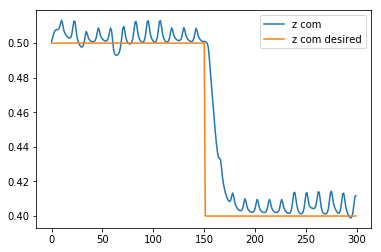

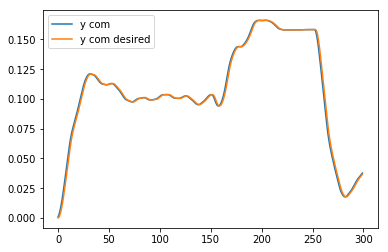

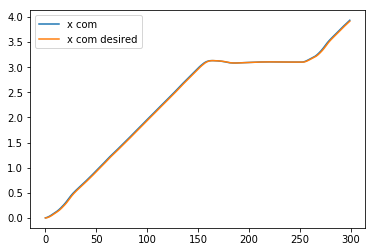

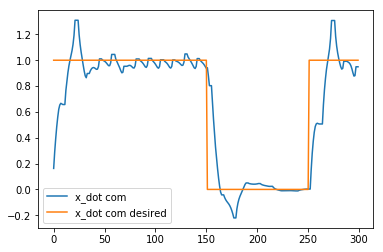

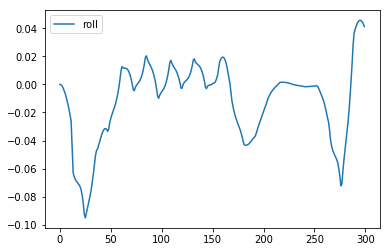

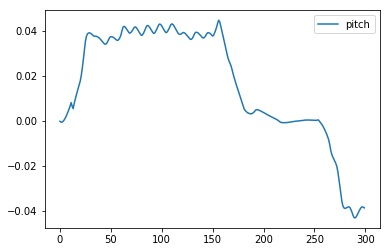

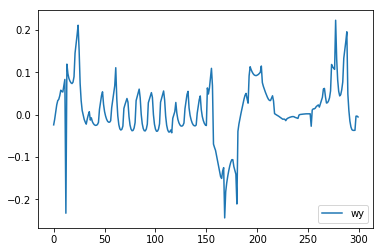

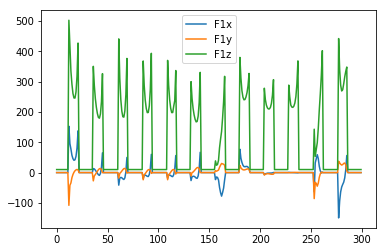

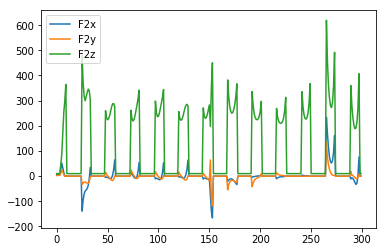

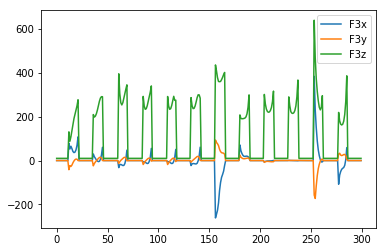

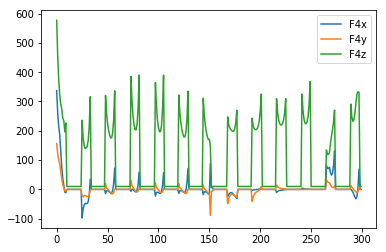

In [13]:

# MPC Optimization Portion

from casadi import *
import numpy as np


# Model Params

"""
m = 20 # Body Mass
m_inv = 1/m

# Moment of Inertia at Center of Mass   (kg m^2)
Ixx = 0.397
Ixy = -2.788E-05
Ixz = -1.469E-07
Iyx = -2.788E-05
Iyy = 0.098
Iyz = 6.494E-07
Izx = -1.469E-07
Izy = 6.494E-07
Izz = 0.454

"""
 
# Setup our prediction horizons
K = 24 # Prediction Steps (16 Steps is ideal)
T = 0.5 # Horizon Length (seconds) (0.5 second ideal window)
dt = T/K # Time step

# How many steps to simulate
# TODO: This 300 actually be sim time... 
sim_steps = 300

t_vec = np.linspace(0,T,K+1) # Plotting time vector

# CoM Trajectory generator.  Match horizon length and sample points
ctg = CoMTrajectoryGenerator(length = T, sample_points=K)

# Setup our Plants:
# We create 2 plants here:
# One for rolling out the MPC simulations for optimization.
# Other is for time stepping the actual plant with the output from the MPC.  The true estimated state is then fed back
# as the initial condition to the next run of the MPC.  Right now it is simulated as I have no "real" quad plant yet :P

# Plant for MPC Rollouts
nomad_mpc = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], 
                                  width=400e-3, 
                                  height=200e-3, 
                                  length= 600e-3, 
                                  Ts=dt)
# Actual plant
nomad_plant = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], 
                                  width=400e-3, 
                                  height=200e-3, 
                                  length= 600e-3, 
                                  Ts=dt)

# Setup Gait
#gait = LateralSeqWalkGaitSequencer(period = 0.5, segments = 100)
#gait = PronkingGaitSequencer(period = 0.5, segments = 100)
gait = RunningTrotGaitSequencer(period = 0.5, segments = 100)
#gait = WalkingTrotGaitSequencer(period = 0.5, segments = 100)
#gait = StandingGaitSequencer(period = 0.5, segments = 100)
#gait = WalkingPaceGaitSequencer(period = 0.5, segments = 100)
#gait = RunningPaceGaitSequencer(period = 0.5, segments = 100)
#gait = BoundingGaitSequencer(period = 0.3, segments = 100)
gait.start(0)

track_offset = 0.06

# Vectors for caching simulation output for plotting
u_sim = np.zeros((nomad_mpc.num_inputs,sim_steps))
x_sim = np.zeros((nomad_mpc.num_states,sim_steps))
x_refsim = np.zeros((nomad_mpc.num_states,sim_steps))

# Init the visualizer for the plant
nomad_plant.init_visualizer(vis)

# Set Gait
nomad_plant.set_gait(gait)

# Setup our dynamics constraint callback function
f = lambda A,B,x,u: A@x+B@u #dx/dt = f(x,u)

######################################
# State and Input Weighting
######################################
# Higher weight on our Z position.  Everything else equal(1).  Maybe higher weights on some of the body
# Orientation to help different gaits?
Q = np.diag(np.array([1,1,50,1,1,1,10,20,1,1,1,1,1])) # State Weighting

alpha = 1e-6
R = np.eye(nomad_mpc.num_inputs)*alpha # Input Weighting

######################################
# Initial Conditions
######################################
nomad_plant.set_com_pos(np.array([0.0,0.0,0.5]))
nomad_plant.set_com_vel(np.array([0.0,0.0,0.0]))
nomad_plant.set_orientation(np.array([0.0,0.0,0.0]))
nomad_plant.set_angular_vel(np.array([0.0,0.0,0.0]))

# TODO: Need a better way of setting up the MPC plant from the Reference plant. "GetCopy" or something
# Copy over to the MPC plant
nomad_mpc.x = nomad_plant.x
nomad_mpc.set_gait(nomad_plant.get_gait())

# Set Track
nomad_plant.set_track_offset(track_offset)
nomad_plant.reset_foot_positions()

nomad_mpc.set_track_offset(track_offset)
nomad_mpc.reset_foot_positions()

# Cache initial state
initial_state = nomad_plant.x

######################################
# Opti Setup
######################################
opti = Opti() # Optimization problem

# Print and debug options
p_opts = {"print_time":False}
s_opts = {"print_level":1, "max_iter":50}

# Using ipopt non linear solver.  May do qpOases as full quadratic for increased frequency
opti.solver('ipopt', p_opts, s_opts)

######################################
# Decision Variables
######################################
X = opti.variable(nomad_mpc.num_states,K+1) # State Vector = [x,y,z,x',y',z', phi, theta, psi, omega_x, omega_y, omega_z].T
U = opti.variable(nomad_mpc.num_inputs,K+1) # Input Vector = [f1_x, f1_y, f1_z,...,fn_x,fn_y,fn_z].T

######################################
# Opti Parameters
# These are the values that change between runs.  Can be updated without reinitializing the solver
######################################
x0 = opti.parameter(nomad_mpc.num_states,1); # Initial Condition
X_ref = opti.parameter(nomad_mpc.num_states,K+1); # Trajectory

# Time Varying Matrix Containers:
A_hat = [] # State Transition Matrix
B_hat = [] # Input Matrix
for n in range(K):     
    A_hat.append(opti.parameter(nomad_mpc.num_states,nomad_mpc.num_states)); # State Transition Matrix
    B_hat.append(opti.parameter(nomad_mpc.num_states,nomad_mpc.num_inputs)); # Input Matrix
    

######################################
# Dyanamics Constraints
# (Direct Transciption w/ Multiple Shooting)
######################################
opti.subject_to(X[:,0] == x0)
for n in range(K):       
    opti.subject_to(X[:, n+1] == f(A_hat[n],B_hat[n],X[:, n], U[:, n])) # Discrete Time
        
######################################
# Input Constraints
######################################

# Setup our Friction Cone Constraints
# TODO: Would be cool to implement say a NN to try to "learn" the ground friction over time by detecting slips, etc.
# and adjusting an adaptable parameter over time
mu = opti.parameter()
opti.set_value(mu, 0.6)

for i in range(nomad_mpc.num_forces):
    
    # Create some helper variables
    f_x = U[0+(i*3),:]
    f_y = U[1+(i*3),:]
    f_z = U[2+(i*3),:]
    
    # Resisitive Friction Force
    f_r = mu*f_z 
    
    # Eq (22) Dynamic Locomotion in the MIT Cheetah 3 Through Convex Model-Predictive Control
    opti.subject_to(nomad_mpc.force_min <= f_z)
    opti.subject_to(f_z <= nomad_mpc.force_max)
    
    # Eq (23) Dynamic Locomotion in the MIT Cheetah 3 Through Convex Model-Predictive Control
    opti.subject_to(-f_r <= f_x)
    opti.subject_to(-f_r <= -f_x)
    opti.subject_to(f_x <= f_r)
    opti.subject_to(-f_x <= f_r)
    
    # Eq (24) Dynamic Locomotion in the MIT Cheetah 3 Through Convex Model-Predictive Control
    opti.subject_to(-f_r <= f_y)
    opti.subject_to(-f_r <= -f_y)
    opti.subject_to(f_y <= f_r)
    opti.subject_to(-f_y <= f_r)
    
######################################
# Objective Function
# error = X - X_ref (Reference Trajectory Error)
# control effor = min(U)
######################################
cost = sum([(X[:, i]-X_ref[:, i]).T@Q@(X[:, i]-X_ref[:, i]) for i in range(K+1)]) + sum([U[:, i].T@R@U[:,i] for i in range(K)])

# Minimize our cost: Error between state and reference trajectory and Minimize input force
opti.minimize(cost)
        
print(opti.p)
print(opti.np)
for i in range(sim_steps):
    
    #clear_output(wait=True)
    #print("sim_step=", i)

    # TODO: Also need to copy foot positions somehow.  Right now we are "stepping" the MPC at the end to get around this.
    # Kind of crap
    # Copy over to the MPC plant for next iteration
    nomad_mpc.x = nomad_plant.x
    
    # Sync times
    nomad_mpc.t = nomad_plant.t

    ######################################
    # Generate Reference Trajectory
    # TODO: Probably move this function out and these need
    # to be the commanded values from the operator/high level planner
    ######################################
    if(i > 250):
        y = ctg.generate(nomad_mpc.x.flatten(), x_dot = 1.0, y_dot = 0.0, yaw_dot = 0.0, z_com = 0.4)
    elif(i > 150):
        y = ctg.generate(nomad_mpc.x.flatten(), x_dot = 0., y_dot = 0.0, yaw_dot = 1.4, z_com = 0.4)
    else:
        y = ctg.generate(nomad_mpc.x.flatten(), x_dot = 1.0, y_dot = 0.0, yaw_dot = 0.0, z_com = 0.5)
    
    #print(y)

    ######################################
    # Update Parameters
    ######################################
    
    # Update intial conditions
    opti.set_value(x0, nomad_mpc.x)
    
    # Update reference trajectory
    opti.set_value(X_ref, y);
    
    # Update State and Input model matrices from the reference trajectory
    A, B, A_d, B_d = nomad_mpc.get_model_matrices(y)
    
    for n in range(K): # Loop and update time varying model matrices for next time step
        opti.set_value(A_hat[n], A_d[n])
        opti.set_value(B_hat[n], B_d[n])

    # Solve it!
    try:
        sol = opti.solve()
        U_sol = sol.value(U)
        X_sol = sol.value(X)
        #print("Optimal")
    except RuntimeError: # TPDP" This could be a lot of other things.  But for now trying to catch the max iterations error
        # TODO: Check actual return status here from sol
        # Alert "Non Optimal Value"
        #print("Non Optimal")
        U_sol = opti.debug.value(U)
        X_sol = opti.debug.value(X)
        pass
        
    # Get the optimized u vector. We use only the first optimial control input.
    u = U_sol[:,0].reshape(-1,1)

    # Step our plant with the first optimized control input
    nomad_plant.step(u)
    
    # TODO: Need a way to step our gait forward.  We don't care to step our dynamics necessarily.
    # Need to copy foot positions also from the plant after we step it...
    nomad_mpc.step(u)
    
    # Cache some values for plotting and simulation later
    u_sim[:, i] = u.T
    x_sim[:, i] = nomad_plant.x.T
    x_refsim[:, i] = y[:,0]
    
    # TODO: Remove this.  Only here for now.  Should be in a seperate render thread/external physics sim
    #nomad_plant.render()
    #pose_vis.render()
    
    # Update our next iteration initial guess
    opti.set_initial(U, U_sol);
    
    # TODO: Should be from our plant...
    opti.set_initial(X, X_sol);
    
######################################
# Render and Plot Output
######################################

# Reset our plant
nomad_plant.t = 0
nomad_plant.x = initial_state

##########################################
#
#
#############################################
nomad_plant = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], 
                                  width=400e-3, 
                                  height=200e-3, 
                                  length= 600e-3, 
                                  Ts=dt)

# Init the visualizer for the plant
nomad_plant.init_visualizer(vis)

# This section just renders last output without going through the solver
nomad_plant.x = initial_state
#print(initial_state)

# Set Gait
nomad_plant.set_gait(gait)

# Set Track
nomad_plant.set_track_offset(track_offset)
nomad_plant.reset_foot_positions()
nomad_plant.t = 0


pose_vis = TransformPoseVisualizer()
pose_vis.init_visualizer(vis)


#time.sleep(15)
for i in range(sim_steps):
    nomad_plant.step(u_sim[:, i].reshape(-1,1))
    nomad_plant.render()
    pose_vis.render()
    time.sleep(dt)
    
    
# Graph the output
# Note: This only has data from the last sim step run so isn't the ENTIRE trajectory.
# Would need to save the state of all these values to plot the full trajectory.
from pylab import plot, step, figure, legend, show, spy

figure()
plot(x_sim[2,:],label="z com")
plot(x_refsim[2,:],label="z com desired")
legend(loc="best")

figure()
plot(x_sim[1,:],label="y com")
plot(x_refsim[1,:],label="y com desired")
legend(loc="best")

figure()
plot(x_sim[0,:],label="x com")
plot(x_refsim[0,:],label="x com desired")
legend(loc="best")

figure()
plot(x_sim[3,:],label="x_dot com")
plot(x_refsim[3,:],label="x_dot com desired")
legend(loc="best")

figure()
plot(x_sim[6,:],label="roll")
legend(loc="best")

figure()
plot(x_sim[7,:],label="pitch")
legend(loc="best")

figure()
plot(x_sim[10,:],label="wy")
legend(loc="best")

figure()
plot(u_sim[0,:],label="F1x")
plot(u_sim[1,:],label="F1y")
plot(u_sim[2,:],label="F1z")
legend(loc="best")
#step(t_vec,u_sim[2,:],'k',label="Fz1")

figure()
plot(u_sim[3,:],label="F2x")
plot(u_sim[4,:],label="F2y")
plot(u_sim[5,:],label="F2z")
legend(loc="best")
#step(t_vec,u_sim[5,:],'k',label="Fz2")

figure()
plot(u_sim[6,:],label="F3x")
plot(u_sim[7,:],label="F3y")
plot(u_sim[8,:],label="F3z")
legend(loc="best")
#step(t_vec,u_sim[8,:],'k',label="Fz3")

figure()
plot(u_sim[9,:],label="F4x")
plot(u_sim[10,:],label="F4y")
plot(u_sim[11,:],label="F4z")
legend(loc="best")
#step(t_vec,u_sim[11,:],'k',label="Fz4")



In [12]:
nomad_plant = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], 
                                  width=400e-3, 
                                  height=200e-3, 
                                  length= 600e-3, 
                                  Ts=dt)

# Init the visualizer for the plant
nomad_plant.init_visualizer(vis)

# This section just renders last output without going through the solver
nomad_plant.x = initial_state
#print(initial_state)

# Set Gait
nomad_plant.set_gait(gait)

# Set Track
nomad_plant.set_track_offset(track_offset)
nomad_plant.reset_foot_positions()
nomad_plant.t = 0


pose_vis = TransformPoseVisualizer()
pose_vis.init_visualizer(vis)


#time.sleep(15)
for i in range(sim_steps):
    nomad_plant.step(u_sim[:, i].reshape(-1,1))
    nomad_plant.render()
    pose_vis.render()
    time.sleep(dt)
    
    